# Enrich locations and parse with GeoPandas

This tutorial runs the Geocoding and Places Details APIs on a few thousand address records. We show how to preprocess tabular data as input and briefly discuss address validation. In addition, you will learn how to leverage the GeoJSON format to store results in GeoDataFrames. To summarize, you will learn how to enrich and prepare your data for Python's geo-analytics technology stack.

You want to repeat all the steps below on your own data? Check out how to [install a Conda virutal environment](install.md) and make sure to add `geoapify`, `geopandas`, and `seaborn`.

## Part 1 - data preprocessing

We used random geocoordinates and Geoapify's reverse geocoding service to generate the following dataset. A real-world use case inspired us in the distribution of the coordinates, with the majority concentrated in a small country and otherwise scattered worldwide.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = None  # to display all columns

In [2]:
df = pd.read_csv('locations-sample.csv', usecols=['Street', 'Housenumber', 'Postcode', 'City', 'Country'])
print(f'Total number of records: {df.shape[0]}')
df.head()

Total number of records: 3823


,Street,Housenumber,Postcode,City,Country
0,Leidsekade,90-4A,1017PN,Amsterdam,Netherlands
1,Pirath,17,4952,Weng im Innkreis,Austria
2,Voorplecht,10,9934RZ,Delfzijl,Netherlands
3,Tets Van Goudriaanstraat,21,1411VA,Naarden,Netherlands
4,Industrieweg,18,5145PV,Waalwijk,Netherlands


Geoapify's geocoding service accepts free text search and structured input, the latter being helpful only if we have a lot of faith in our data quality. Unfortunately, I have seen many data quality issues in real-world structured address records. And my conclusion always was to go for the free text search. Here, we parse the structured data into one string per row.

We have used the typical German layout for the concatenation. But we must admit, we have not spent much time optimizing this step.

In [3]:
def concat_columns(df: pd.DataFrame, sep: str = ' ', fill_value: str = np.nan) -> pd.Series:
    """Concatenates row-wise all columns of df and returns series with same index.
    
    """
    return (df.apply(lambda s: sep.join(s.dropna().astype(str).str.strip().replace('', np.nan).dropna()), axis=1)
            .replace('', fill_value))

df['AddressLine1'] = concat_columns(df=df[['Street', 'Housenumber']])
df['AddressLine2'] = concat_columns(df=df[['Postcode', 'City']])
addresses = concat_columns(df[['AddressLine1', 'AddressLine2', 'Country']], sep=', ', fill_value='')
addresses[:5]

0      Leidsekade 90-4A, 1017PN Amsterdam, Netherlands
1            Pirath 17, 4952 Weng im Innkreis, Austria
2          Voorplecht 10, 9934RZ Delfzijl, Netherlands
3    Tets Van Goudriaanstraat 21, 1411VA Naarden, N...
4        Industrieweg 18, 5145PV Waalwijk, Netherlands
dtype: object

## Part 2 - add geocodes

It is time to geocode our addresses. You can do this using our Python API but we prefer the command line. But first we prepare the input file using Python:

In [4]:
from geoapify.batch import parse_geocoding_inputs, simplify_batch_geocoding_results
from geoapify.utils import write_data_to_json_file, read_data_from_json_file

In [5]:
data = {
    'api': '/v1/geocode/search',  # This tells Geoapify which service to run.
    'inputs': parse_geocoding_inputs(locations=addresses),
    'params': {'limit': 1, 'format': 'geojson'},  # We strongly recommend using GeoJSON as output format.
    'batch_len': 500,  # Results in math.ceil(3823 / 500) = 8 jobs in total.
    'id': 'tutorial-batch-geocode'
}
write_data_to_json_file(data=data, file_path='tutorial-geocode-input.json')

It is time to switch to the CLI. First we submit jobs to Geoapify servers with

```shell
geoapify post-batch-jobs tutorial-geocode-input.json tutorial-geocode-urls.json
```

The output of the first step `tutorial-geocode-urls.json` is the input for the next:

```shell
geoapify monitor-batch-jobs tutorial-geocode-urls.json tutorial-geocode-results.json
```

Processing on the Geoapify servers can take some time, depending on the size of your inputs, your subscription plan, and how busy the servers are. Pause here and continue after all your jobs are done.

We convert the results into a simplified list of [GeoJSON](https://geojson.org/)-like Python dictionaries. 

In [6]:
results = read_data_from_json_file('tutorial-geocode-results.json')['results']
results = simplify_batch_geocoding_results(results=results, input_format='geojson')

print('Here is how the 1st one looks like:')
results[0]

Here is how the 1st one looks like:


{'type': 'Feature',
 'properties': {'datasource': {'sourcename': 'openstreetmap',
   'attribution': '© OpenStreetMap contributors',
   'license': 'Open Database License',
   'url': 'https://www.openstreetmap.org/copyright'},
  'housenumber': '90-4A',
  'street': 'Leidsekade',
  'suburb': 'Centrum',
  'city': 'Amsterdam',
  'state': 'North Holland',
  'country': 'Netherlands',
  'postcode': '1017PN',
  'country_code': 'nl',
  'lon': 4.8804893,
  'lat': 52.3640519,
  'formatted': 'Leidsekade 90-4A, 1017 PN Amsterdam, Netherlands',
  'address_line1': 'Leidsekade 90-4A',
  'address_line2': '1017 PN Amsterdam, Netherlands',
  'timezone': {'name': 'Europe/Amsterdam',
   'name_alt': 'Europe/Brussels',
   'offset_STD': '+01:00',
   'offset_STD_seconds': 3600,
   'offset_DST': '+02:00',
   'offset_DST_seconds': 7200,
   'abbreviation_STD': 'CET',
   'abbreviation_DST': 'CEST'},
  'result_type': 'building',
  'rank': {'importance': 0.30100000000000005,
   'popularity': 8.995467104553104,
   'con

[GeoPandas](https://github.com/geopandas/geopandas) helps us transform the data into a tabular format. The method parses the `geometry` into a [Shapely](https://github.com/shapely/shapely) geometric object, puts all `properties` into separate columns, and ignores the rest.

In [7]:
import geopandas as gpd

df_geocodes = gpd.GeoDataFrame.from_features(results)
df_geocodes.head()

,geometry,datasource,housenumber,street,suburb,city,state,country,postcode,country_code,lon,lat,formatted,address_line1,address_line2,timezone,result_type,rank,place_id,county,state_code,district,name,category,distance,old_name,county_code,village,town
0,POINT (4.88049 52.36405),"{'sourcename': 'openstreetmap', 'attribution':...",90-4A,Leidsekade,Centrum,Amsterdam,North Holland,Netherlands,1017PN,nl,4.880489,52.364052,"Leidsekade 90-4A, 1017 PN Amsterdam, Netherlands",Leidsekade 90-4A,"1017 PN Amsterdam, Netherlands","{'name': 'Europe/Amsterdam', 'name_alt': 'Euro...",building,"{'importance': 0.30100000000000005, 'popularit...",5167e9affc9e85134059f945ae40992e4a40f00103f901...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (13.20840 48.24926),"{'sourcename': 'openaddresses', 'attribution':...",17,Pirath,NaN,Weng im Innkreis,Upper Austria,Austria,4952,at,13.208404,48.249261,"Pirath 17, 4952 Weng im Innkreis, Austria",Pirath 17,"4952 Weng im Innkreis, Austria","{'name': 'Europe/Vienna', 'offset_STD': '+01:0...",building,"{'popularity': 3.7324997449881105, 'confidence...",510fb6d8edb36a2a40598995d1c8e71f4840c00203e203...,Braunau am Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (6.91636 53.32528),"{'sourcename': 'openstreetmap', 'attribution':...",10,Voorplecht,NaN,Delfzijl,Groningen,Netherlands,9934RZ,nl,6.916363,53.325275,"Voorplecht 10, 9934 RZ Delfzijl, Netherlands",Voorplecht 10,"9934 RZ Delfzijl, Netherlands","{'name': 'Europe/Amsterdam', 'name_alt': 'Euro...",building,"{'importance': 0.21100000000000002, 'popularit...",517e1585025baa1b4059bf98d29fa2a94a40f00103f901...,NaN,GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (5.14943 52.29985),"{'sourcename': 'openstreetmap', 'attribution':...",21,Tets van Goudriaanstraat,NaN,Naarden,North Holland,Netherlands,1411VA,nl,5.149427,52.299848,"Tets van Goudriaanstraat 21, 1411 VA Naarden, ...",Tets van Goudriaanstraat 21,"1411 VA Naarden, Netherlands","{'name': 'Europe/Amsterdam', 'name_alt': 'Euro...",building,"{'importance': 0.411, 'popularity': 6.29033966...",51b1845a7803991440596f21d96d61264a40f00103f901...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (5.06276 51.69443),"{'sourcename': 'openaddresses', 'attribution':...",18,Industrieweg,Industrieterrein Haven,Waalwijk,North Brabant,Netherlands,5145PV,nl,5.062756,51.694427,"Industrieweg 18, 5145 PV Waalwijk, Netherlands",Industrieweg 18,"5145 PV Waalwijk, Netherlands","{'name': 'Europe/Amsterdam', 'name_alt': 'Euro...",building,"{'popularity': 6.875405750665471, 'confidence'...",51d882de1b4340144059cd3ae3fbe2d84940c00203e203...,NaN,NaN,Waalwijk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And we flatten `dict` columns using `pandas.json_normalize`:

In [8]:
df_rank = pd.json_normalize(df_geocodes['rank'])
df_rank

,importance,popularity,confidence,confidence_city_level,confidence_street_level,match_type
0,0.301,8.995467,1.000000,1.0,1.000000,full_match
1,NaN,3.732500,1.000000,1.0,1.000000,full_match
2,0.211,5.711331,1.000000,1.0,1.000000,full_match
3,0.411,6.290340,1.000000,1.0,1.000000,full_match
4,NaN,6.875406,1.000000,1.0,1.000000,full_match
...,...,...,...,...,...,...
3818,NaN,6.240791,1.000000,1.0,1.000000,full_match
3819,0.301,5.338441,1.000000,1.0,1.000000,full_match
3820,0.111,6.179335,0.818182,1.0,0.818182,full_match
3821,0.301,8.232001,1.000000,1.0,1.000000,full_match


## Part 3 - validate location data quality

In [9]:
df_geocodes.result_type.value_counts()

building    3147
street       354
amenity      286
postcode      19
city          12
suburb         3
district       2
Name: result_type, dtype: int64

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

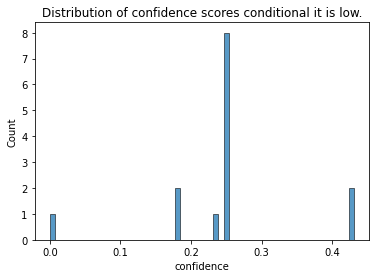

In [11]:
low_confidence = df_rank['confidence'].lt(0.5)
(sns.histplot(data=df_rank.loc[low_confidence], x='confidence')
 .set_title('Distribution of confidence scores conditional it is low.'))
plt.show()

In [12]:
use_cols = ['street', 'housenumber', 'postcode', 'city', 'country', 'result_type', 'name']
df_geocodes.loc[low_confidence, use_cols]

,street,housenumber,postcode,city,country,result_type,name
420,NaN,NaN,6531,Ried im Oberinntal,Austria,amenity,Ried i. O. Gemeindeamt
636,Georgenthalstraße,6,6112,Wattens,Austria,building,NaN
755,NaN,NaN,6603,Alverna,Netherlands,city,NaN
1041,NaN,NaN,6330,Stadt Kufstein,Austria,postcode,NaN
1201,Josef-Mühlbacher-Straße,17,6200,Jenbach,Austria,building,NaN
1483,NaN,NaN,6191,Neerbeek,Netherlands,postcode,Neerbeek
1616,NaN,NaN,6531,Ried im Oberinntal,Austria,amenity,Ried i. O. Gemeindeamt
1823,NaN,NaN,NaN,Stadt Dornbirn,Austria,city,NaN
2112,NaN,NaN,NaN,Floriana,Malta,city,NaN
2151,Kleindorf,4,9142,Globasnitz,Austria,building,NaN


In [13]:
df[low_confidence]

,Street,Housenumber,Postcode,City,Country,AddressLine1,AddressLine2
420,Ried i.O,285,6531,Gemeinde Ried im Oberinntal,Austria,Ried i.O 285,6531 Gemeinde Ried im Oberinntal
636,Georgenthalstraße,6,6112,Marktgemeinde Wattens,Austria,Georgenthalstraße 6,6112 Marktgemeinde Wattens
755,Sint Walrickweg,15,6603,Alverna,Netherlands,Sint Walrickweg 15,6603 Alverna
1041,Römerhofgasse,NaN,6330,Stadt Kufstein,Austria,Römerhofgasse,6330 Stadt Kufstein
1201,Josef-Mühlbacher-Straße,5,6200,Marktgemeinde Jenbach,Austria,Josef-Mühlbacher-Straße 5,6200 Marktgemeinde Jenbach
1483,Chemelot F-weg,24G-04,6191,Neerbeek,Netherlands,Chemelot F-weg 24G-04,6191 Neerbeek
1616,Ried i.O,66a,6531,Gemeinde Ried im Oberinntal,Austria,Ried i.O 66a,6531 Gemeinde Ried im Oberinntal
1823,Webergasse,NaN,6850,Stadt Dornbirn,Austria,Webergasse,6850 Stadt Dornbirn
2112,Triq San Franġisk,NaN,FRN 1040,Floriana,Malta,Triq San Franġisk,FRN 1040 Floriana
2151,NaN,NaN,9831,Kleindorf,Austria,NaN,9831 Kleindorf


## Part 4 - add place details

In [14]:
from geoapify.batch import parse_geocodes, simplify_batch_place_details_results
from geoapify.utils import write_data_to_json_file

geocodes = parse_geocodes(geocodes=[(item.x, item.y) for _, item in df_geocodes['geometry'].items()])
features = ','.join(['details', 'building'])

data = {
    'api': '/v2/place-details',  # See the Geoapify API docs for other batch APIs.
    'inputs': geocodes,
    'params': {'features': features},  # We ask only for the top match per search.
    'batch_len': 500,  # optional - results in math.ceil(3823 / 500) = 8 jobs in total.
    'id': 'tutorial-batch-details'
}

write_data_to_json_file(data=data, file_path='tutorial-details-input.json')

We switch again to the CLI to submit jobs, monitor, and retrieve results:

```shell
geoapify post-batch-jobs tutorial-details-input.json tutorial-details-urls.json
```

The output of the first step `tutorial-details-urls.json` is the input for the next:

```shell
geoapify monitor-batch-jobs tutorial-details-urls.json tutorial-details-results.json
```

Pause here and continue after all your jobs are done.

In [15]:
results = read_data_from_json_file('tutorial-details-results.json')['results']
results = simplify_batch_place_details_results(results)

print('Here is how the 1st one looks like:')
results[0]

Here is how the 1st one looks like:


[{'type': 'Feature',
  'properties': {'feature_type': 'details',
   'building': {'start_date': 1894},
   'categories': ['building'],
   'datasource': {'sourcename': 'openstreetmap',
    'attribution': '© OpenStreetMap contributors',
    'license': 'Open Database Licence',
    'url': 'https://www.openstreetmap.org/copyright',
    'raw': {'osm_id': 267565782,
     'ref:bag': 363100012169852,
     'building': 'yes',
     'osm_type': 'w',
     'start_date': 1894}},
   'place_id': '5118dfadb9918513405970627686a22e4a40f00102f901d6baf20f00000000'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[4.8800349, 52.364174399],
     [4.8800354, 52.364170099],
     [4.8800368, 52.364165999],
     [4.880039, 52.364161899],
     [4.8800421, 52.364158099],
     [4.8800459, 52.364154499],
     [4.8800504, 52.364151299],
     [4.8800555, 52.364148399],
     [4.8800642, 52.364144899],
     [4.8802649, 52.364094799],
     [4.8802714, 52.364099499],
     [4.8803445, 52.364080899],
     [4.88034, 52.36

In [16]:
print('Number of feature types found per location:')
pd.Series([len(res) for res in results]).value_counts()

Number of feature types found per location:


2    3301
1     496
0      26
dtype: int64

In [28]:
from typing import List

def convert_place_details_results_to_dataframe(results: List[dict], index: pd.Index = None) -> pd.DataFrame:
    if index is None:
        index = pd.Index(range(len(results)))
    index_name = index.name if index.name is not None else 'index'
    df_details = pd.concat([gpd.GeoDataFrame.from_features(res).assign(**{index_name: idx})
                            for idx, res in zip(index, results)])
    
    dfs_details = [df_split.set_index(index_name) for _, df_split in df_details.groupby('feature_type')]
    dfs_details = [df_split.rename(columns={col: df_split['feature_type'][0] + '.' + col
                                            for col in df_split.columns})
                   for df_split in dfs_details]
    df_details = pd.concat(dfs_details, axis=1)
    
    prop_null_is_1 = df_details.isnull().mean().eq(1.)
    cols_all_null = prop_null_is_1[prop_null_is_1].index.values
    return df_details.drop([col for col in df_details.columns
                            if col.endswith('feature_type') or col in cols_all_null], axis=1)

In [33]:
df_details = convert_place_details_results_to_dataframe(results=results, index=df.index)

df_details['geometry'] = df_details['building.geometry']
df_details.loc[df_details['geometry'].isnull(), 'geometry'] = df_details['details.geometry']
df_details = df_details.drop(['building.geometry', 'details.geometry'], axis=1)

df_details.head()

,building.building,building.categories,building.datasource,building.place_id,building.area,building.name,building.wiki_and_media,building.city,building.county,building.state,building.postcode,building.country,building.country_code,building.formatted,building.address_line1,building.address_line2,building.lat,building.lon,building.housenumber,building.street,building.restrictions,building.name_other,building.website,building.brand,building.brand_details,building.facilities,building.catering,building.opening_hours,building.contact,building.heritage,building.name_international,building.operator,building.payment_options,building.commercial,building.place_of_worship,building.branch,building.parking,building.description,building.accommodation,building.network,building.operator_details,building.historic,building.craft,building.description_international,building.owner,building.website_other,building.owner_details,details.building,details.categories,details.datasource,details.place_id,details.name,details.wiki_and_media,details.city,details.county,details.state,details.postcode,details.country,details.country_code,details.formatted,details.address_line1,details.address_line2,details.lat,details.lon,details.timezone,details.housenumber,details.street,details.restrictions,details.name_other,details.website,details.brand,details.brand_details,details.facilities,details.catering,details.opening_hours,details.contact,details.heritage,details.name_international,details.operator,details.payment_options,details.commercial,details.place_of_worship,details.branch,details.parking,details.description,details.accommodation,details.network,details.operator_details,details.historic,details.socket_options,details.craft,details.description_international,details.owner,details.website_other,details.owner_details,geometry
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,{'start_date': 1894},[building],"{'sourcename': 'openstreetmap', 'attribution':...",5118dfadb9918513405970627686a22e4a40f00102f901...,2564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'start_date': 1894},[building],"{'sourcename': 'openstreetmap', 'attribution':...",5118dfadb9918513405970627686a22e4a40f00102f901...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4.88003 52.36417, 4.88004 52.36417, ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[administrative, administrative.district_level]","{'sourcename': 'openstreetmap', 'attribution':...",518a5fd042cf582a40594ec12bb73a1f4840f00101f901...,Weng im Innkreis,"{'wikidata': 'Q700177', 'wikipedia': 'de:Weng ...",Weng im Innkreis,Bezirk Braunau am Inn,Upper Austria,4952,Austria,at,"Weng im Innkreis, 4952 Weng im Innkreis, Austria",Weng im Innkreis,"4952 Weng im Innkreis, Austria",48.234479,13.178712,"{'name': 'Europe/Vienna', 'offset_STD': '+01:0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((13.12097 48.24466, 13.12113 48.24458..."
2,"{'type': 'house', 'start_date': 2001}","[building, building.residential]","{'sourcename': 'openstreetmap', 'attribution':...",51308a201752aa1b4059d3c3fdc2a2a94a40f00102f901...,241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'house', 'start_date': 2001}","[building, building.residential]","{'sourcename': 'openstreetmap', 'attribution':...",51308a201752aa1b4059d3c3fdc2a2a94a40f00102f901...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

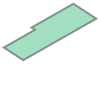

In [34]:
df_details.geometry[123]